In [22]:
import math
import time

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{cmbright}",
    "text.latex.preamble": r"\usepackage{bm}",
    "font.weight": "bold",
})
import networkx as nx
import torch
import torch.nn as nn
from net import gtnet
import numpy as np
from util import *
from generate_index_data import get_stock_data

file_path = './model/model-ind.pt'
model = torch.load(file_path)

In [5]:
device = 'cuda:0'
data = './data/indices.csv'
horizon = 3
normalize = 2
seq_in_len = 24*7
num_nodes = 11 
subgraph_size = 11 
batch_size = 8
num_split = 3

Data = DataLoaderS(data, 0.6, 0.2, device, horizon, seq_in_len, normalize)
model = model.to(device)

print('The receptive field size is', model.receptive_field)
nParams = sum([p.nelement() for p in model.parameters()])
print('Number of model parameters is', nParams, flush=True)

The receptive field size is 187
Number of model parameters is 337585


In [6]:
evaluateL2 = nn.MSELoss(reduction='sum').to(device)
evaluateL1 = nn.L1Loss(reduction='sum').to(device)

In [7]:
def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None

    for X, Y in data.get_batches(X, Y, batch_size, False):
        X = torch.unsqueeze(X,dim=1)
        X = X.transpose(2,3)
        with torch.no_grad():
            output = model(X)
        output = torch.squeeze(output)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m)

    rse = math.sqrt(total_loss / n_samples) / data.rse
    rae = (total_loss_l1 / n_samples) / data.rae

    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    return rse, rae, correlation

In [8]:
test_acc, test_rae, test_corr = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, batch_size)
print("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr), flush=True)

test rse 0.0267 | test rae 0.0246 | test corr 0.9756


In [9]:
A = torch.round(model.gc(model.idx), decimals=4).cpu().detach().numpy()
G = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
mapping = {0: "Italy", 1: r"T\"{u}rkiye", 2: "France", 3: "UK", 4: "Germany", 5: "US", 6: "Canada", 7: "Indonesia", 8: "Mexico", 9: "Japan", 10: "Nigeria"}
H = nx.relabel_nodes(G, mapping)

In [10]:
H.nodes

NodeView(('Italy', 'T\\"{u}rkiye', 'France', 'UK', 'Germany', 'US', 'Canada', 'Indonesia', 'Mexico', 'Japan', 'Nigeria'))

In [11]:
np.round(A, decimals=2)

array([[0.  , 1.  , 1.  , 0.  , 1.  , 0.  , 0.  , 0.98, 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.96, 1.  , 1.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 1.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 0.  , 1.  , 0.99],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.9 , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.81, 1.  , 1.  , 0.  , 0.  , 0.  , 1.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

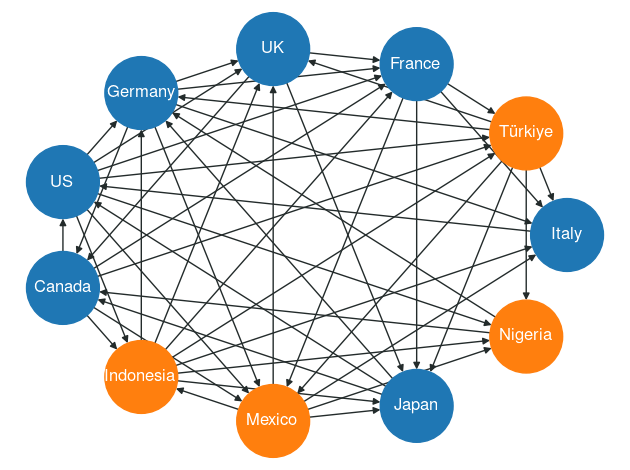

In [12]:
# https://www.color-hex.com/
fig = plt.figure()
ax=fig.add_subplot(111)

mint = '#f0dcdb'
g7 = '#b9ccf3'

# Matplotlib default color
mint = '#ff7f0e'
g7 = '#1f77b4'

nx.draw(H, with_labels=True, node_size=2750, font_size=12, font_color='white', font_weight='bold', font_family='sans-serif', node_color=[g7, mint, g7, g7, g7, g7, g7, mint, mint, g7, mint], edge_color='#232b2b', alpha=1.0, pos=nx.circular_layout(H), ax=ax)
fig.tight_layout()
fig.savefig("graph.eps", format='eps', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [13]:
np.round(A.T, decimals=1)

array([[0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 1. , 0.8, 1. ],
       [1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. ],
       [1. , 0. , 1. , 1. , 0. , 0. , 0.9, 0. , 1. , 0. , 0. ],
       [0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 0. , 1. ],
       [0. , 1. , 1. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 1. ],
       [1. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. ]],
      dtype=float32)

## Time Series Forecasting

In [14]:
batch_size = 1
n_predict = None
n_test = None
predict = None
test = None

for X, Y in Data.get_batches(Data.test[0], Data.test[1], batch_size, False):
    X = torch.unsqueeze(X,dim=1)
    X = X.transpose(2,3)
    with torch.no_grad():
        output = model(X)
    output = torch.squeeze(output)
    if len(output.shape)==1:
        output = output.unsqueeze(dim=0)
    scale = Data.scale.expand(output.size(0), Data.m)
    if predict is None:
        predict = output * scale
        test = Y * scale
        n_predict = output
        n_test = Y
    else:
        predict = torch.cat((predict, output * scale))
        test = torch.cat((test, Y * scale))
        n_predict = torch.cat((n_predict, output))
        n_test = torch.cat((n_test, Y))
        

predict = predict.data.cpu().numpy()
Ytest = test.data.cpu().numpy()
n_predict = n_predict.data.cpu().numpy()
n_Ytest = n_test.data.cpu().numpy()

In [15]:
n_predict.shape, n_Ytest.shape

((917, 11), (917, 11))

In [16]:
Ybar = np.mean(Ytest, axis=0)
Ybar

array([10.212015 ,  8.57868  ,  8.858855 ,  8.935887 ,  9.642615 ,
        8.388082 ,  9.927565 ,  8.852349 , 10.869084 , 10.340662 ,
        7.7504673], dtype=float32)

In [19]:
# RAE, RSE computation
rae = []
rse = []
rae_original = []
rse_original = []
for i in range(11):
    rae += [np.sum(np.abs(predict[:,i] - Ytest[:,i])) / np.sum(np.abs(Ytest[:,i] - Ybar[i]))]
    rae_original += [np.sum(np.abs(np.exp(predict[:,i]) - np.exp(Ytest[:,i]))) / np.sum(np.abs(np.exp(Ytest[:,1]) - np.exp(Ybar[i])))]
    rse += [np.sum((predict[:,i] - Ytest[:,i])**2) / np.sum((Ytest[:,i] - Ybar[i])**2)]
    rse_original += [np.sum((np.exp(predict[:,i]) - np.exp(Ytest[:,i]))**2) / np.sum((np.exp(Ytest[:,1]) - np.exp(Ybar[i]))**2)]
print(np.concatenate([rae, rse], axis=0).reshape(2, 11))
print(np.concatenate([rae_original, rse_original], axis=0).reshape(2, 11))

[[0.16596213 0.07546839 0.22356533 0.48720714 0.21411538 0.19529708
  0.40769517 0.5421083  0.3773056  0.15688458 0.07272823]
 [0.02668864 0.00636233 0.05044551 0.18817528 0.04269908 0.03540778
  0.14861523 0.2946134  0.13268152 0.02931795 0.00767869]]
[[0.02588295 0.08087225 0.04516085 0.04443449 0.03237887 0.0306321
  0.02413407 0.03683262 0.02067925 0.02535415 0.01263268]
 [0.00095017 0.00768889 0.00224719 0.00193497 0.00134433 0.00085453
  0.00075588 0.00144217 0.00063326 0.00104391 0.00024285]]


In [18]:
# MAE, MAPE, RMSE computation
rmse = []
mae = []
mape = []
rmse_original = []
mae_original = []
mape_original = []
for i in range(11):
    rmse += [np.sqrt(np.mean((predict[:,i] - Ytest[:,i])**2))]
    rmse_original += [np.sqrt(np.mean((np.exp(predict[:,i]) - np.exp(Ytest[:,i]))**2))]
    mae += [np.mean(np.abs(predict[:,i] - Ytest[:,i]))]
    mae_original += [np.mean(np.abs(np.exp(predict[:,i]) - np.exp(Ytest[:,i])))]
    mape += [np.mean(np.abs(predict[:,i] - Ytest[:,i]) / Ytest[:,i]) * 100]
    mape_original += [np.mean(np.abs(np.exp(predict[:,i]) - np.exp(Ytest[:,i])) / np.exp(Ytest[:,i])) * 100]
print(np.concatenate([rmse, mae, mape], axis=0).reshape(3, 11))
print(np.concatenate([rmse_original, mae_original, mape_original], axis=0).reshape(3, 11))

[[0.02403746 0.04162634 0.02021854 0.01851122 0.02330163 0.0212443
  0.01975246 0.01603352 0.02231239 0.02452193 0.02561362]
 [0.02000798 0.03335006 0.01681012 0.01588845 0.01969035 0.0181473
  0.01705102 0.01371825 0.01833914 0.0197852  0.01846292]
 [0.19585693 0.38958818 0.18982702 0.17768675 0.20412472 0.21619338
  0.17163255 0.15488836 0.1685936  0.19078308 0.23649386]]
[[ 659.28552246  252.04637146  140.5645752   140.848526    358.95022583
    94.3418045   404.99755859  112.02615356 1172.36791992  810.94128418
    72.1812973 ]
 [ 548.86950684  194.78514099  117.66982269  120.58409119  303.87692261
    80.26811981  349.09545898   95.68595123  961.67932129  632.43322754
    47.11144257]
 [   1.98254064    3.277345      1.6694529     1.57561563    1.95008218
     1.80073921    1.68952234    1.36197777    1.81154311    1.95758492
     1.81840844]]


In [21]:
original_data = get_stock_data(dt.datetime(2005, 1, 3), dt.datetime(2024, 8, 15))

[*********************100%%**********************]  10 of 10 completed
/home/icute/repos/research/graph-nn/mtgnn/generate_index_data.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nse30['Open'].iloc[i] = locale.atof(nse30['Open'].iloc[

In [26]:
idx = pd.date_range(
    original_data.index[0].date(),
    original_data.index[-1].date(),
)
idx[int(len(idx)*0.8)::200]

DatetimeIndex(['2022-02-10', '2022-08-29', '2023-03-17', '2023-10-03',
               '2024-04-20'],
              dtype='datetime64[ns]', freq='200D')

### Create training, validation and test dataset for Nurbanu

In [19]:
train = pd.DataFrame(Data.rawdat[:int(Data.dat.shape[0]*.6)]).map(lambda x: np.exp(x))
valid = pd.DataFrame(Data.rawdat[int(Data.dat.shape[0]*.6):int(Data.dat.shape[0]*.8)]).map(lambda x: np.exp(x))
test = pd.DataFrame(Data.rawdat[int(Data.dat.shape[0]*.8):int(Data.dat.shape[0])]).map(lambda x: np.exp(x))


In [20]:
print(idx[int(len(idx)*0.0):int(len(idx)*0.6)])
print(idx[int(len(idx)*0.6):int(len(idx)*0.8)])
print(idx[int(len(idx)*0.8)])

DatetimeIndex(['2012-01-30', '2012-01-31', '2012-02-01', '2012-02-02',
               '2012-02-03', '2012-02-04', '2012-02-05', '2012-02-06',
               '2012-02-07', '2012-02-08',
               ...
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08'],
              dtype='datetime64[ns]', length=2748, freq='D')
DatetimeIndex(['2019-08-09', '2019-08-10', '2019-08-11', '2019-08-12',
               '2019-08-13', '2019-08-14', '2019-08-15', '2019-08-16',
               '2019-08-17', '2019-08-18',
               ...
               '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03',
               '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07',
               '2022-02-08', '2022-02-09'],
              dtype='datetime64[ns]', length=916, freq='D')
2022-02-10 00:00:00


In [21]:
train.insert(0, 'Date', idx[int(len(idx)*0.0):int(len(idx)*0.6)])
valid.insert(0, 'Date', idx[int(len(idx)*0.6):int(len(idx)*0.8)])
test.insert(0, 'Date', idx[int(len(idx)*0.8):int(len(idx)*1.0)])
indices = pd.concat([train, valid, test])

In [25]:
# train.to_csv('train.csv', index=False, header=False)
# valid.to_csv('valid.csv', index=False, header=False)
# test.to_csv('test.csv', index=False, header=False)
# indices.to_csv('indices.csv', index=False, header=False)
train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)
test.to_csv('test.csv', index=False)
indices.to_csv('indices.csv', index=False)

In [30]:
from matplotlib import dates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


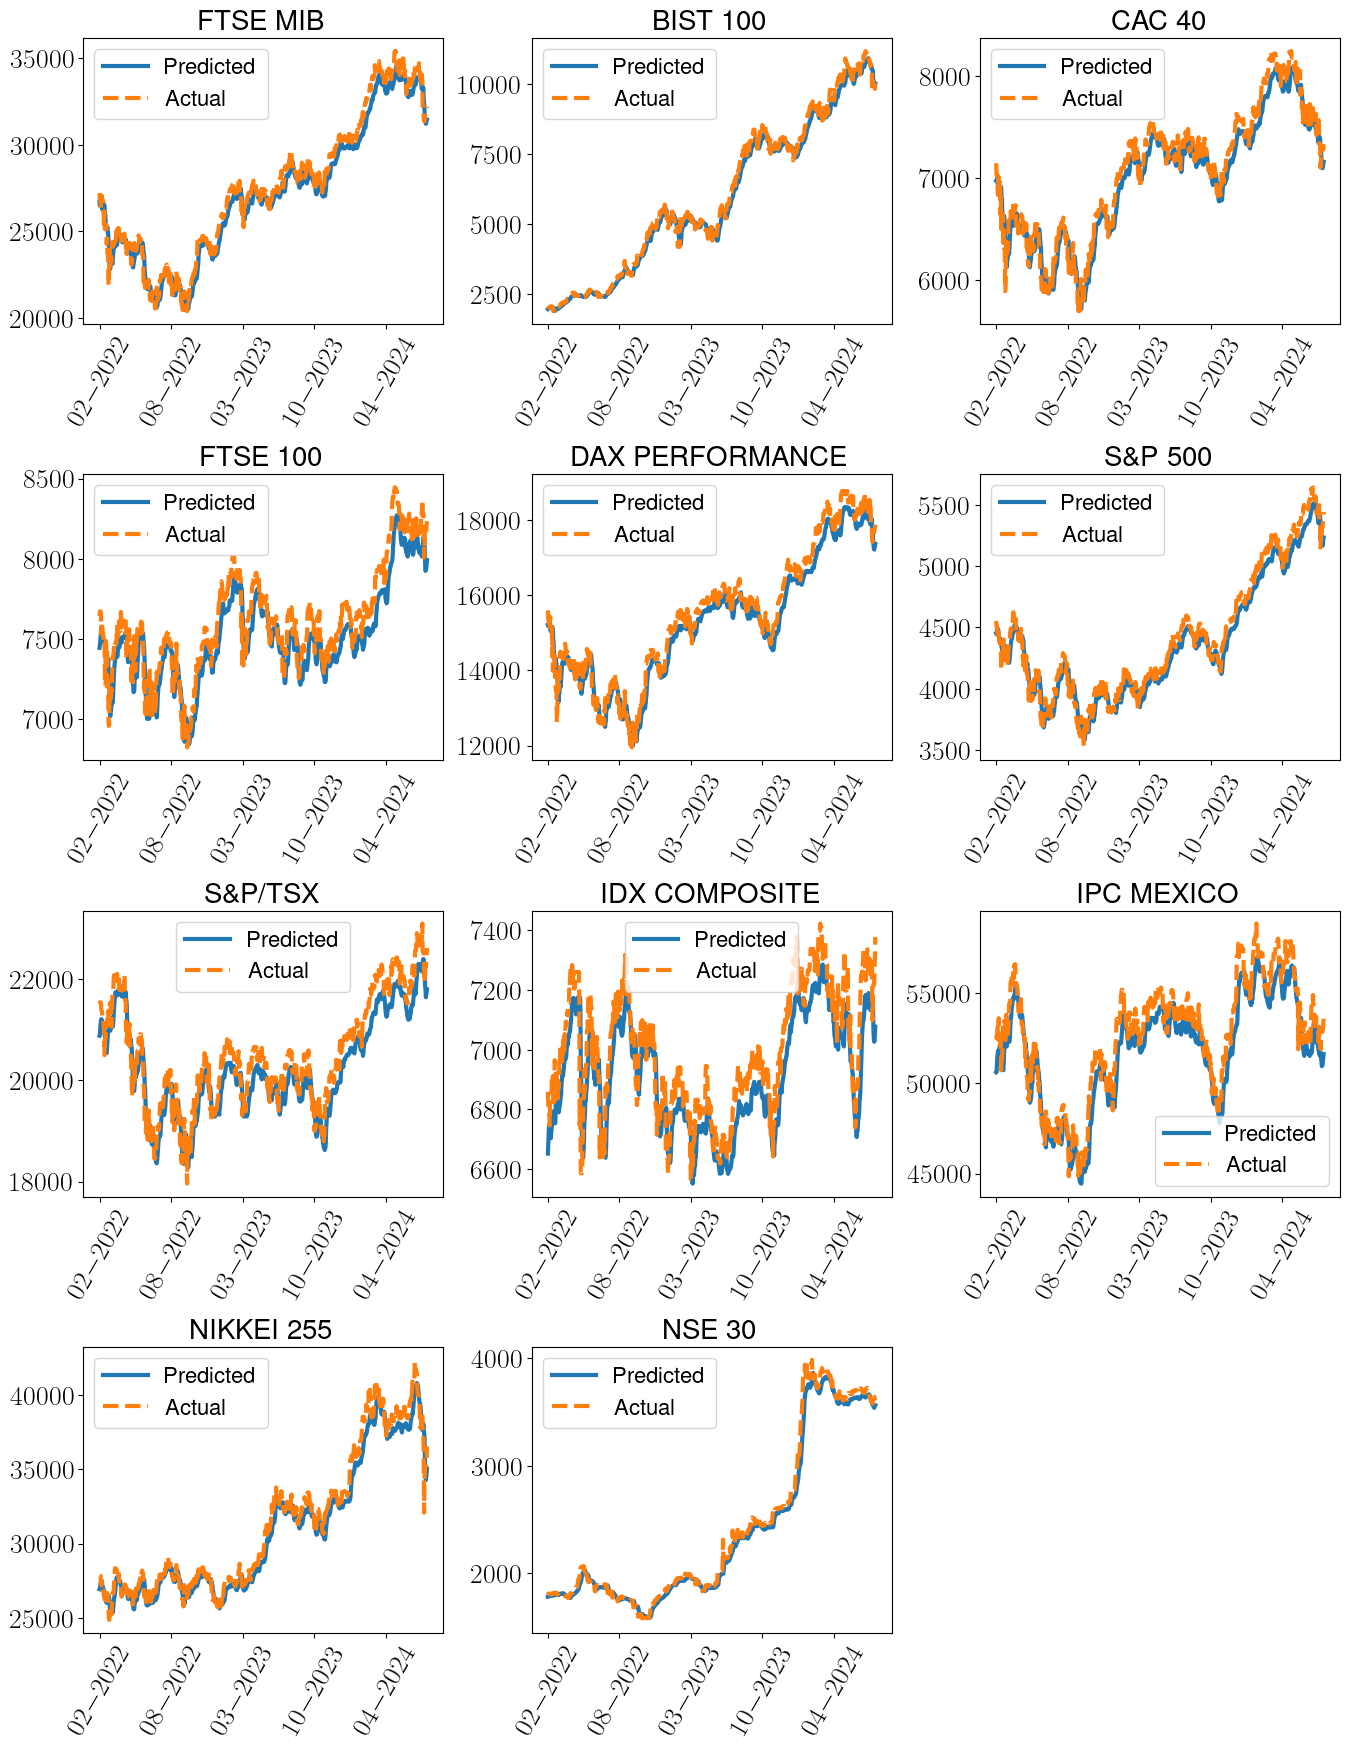

In [74]:
labels = ['FTSE MIB', 'BIST 100', 'CAC 40', 'FTSE 100', 'DAX PERFORMANCE', 'S\&P 500', 'S\&P/TSX', 'IDX COMPOSITE', 'IPC MEXICO', 'NIKKEI 255', 'NSE 30']

fig = plt.figure(figsize=(8.5*1.6, 11*1.6))
for i in range(8):
    ax = fig.add_subplot(4,3, 1+i)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,i]), label=r'Predicted', linewidth=3)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,i]), label=r'Actual', linewidth=3, linestyle='dashed')
    ax.set_title(labels[i], fontsize=20)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
    plt.xticks(rotation=60)
    plt.legend(loc='best', fontsize=16)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xticks(idx[int(len(idx)*0.8)::200])
#     ax.set_xticks([])
    
    
for i in range(8, 11):
    ax = fig.add_subplot(4,3, 1+i)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,i]), label=r'Predicted', linewidth=3)
    ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,i]), label=r'Actual', linewidth=3, linestyle='dashed')
    ax.set_title(labels[i], fontsize=20)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
    plt.xticks(rotation=60)
    plt.legend(loc='best', fontsize=16)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xticks(idx[int(len(idx)*0.8)::200])

fig.tight_layout()
# ax = fig.add_subplot(431)
# ax.plot(idx[int(len(idx)*0.8):], np.exp(predict[:,5]), label='Predicted', linewidth=3)
# ax.plot(idx[int(len(idx)*0.8):], np.exp(Ytest[:,5]), label='Real', linewidth=3, linestyle='dashed')
# ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
# plt.xticks(rotation=60)
# plt.legend(loc='best', fontsize=20)
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)
fig.savefig("predictions.eps", format='eps', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [53]:
dt.datetime(2024, 8, 15)

datetime.datetime(2024, 8, 15, 0, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


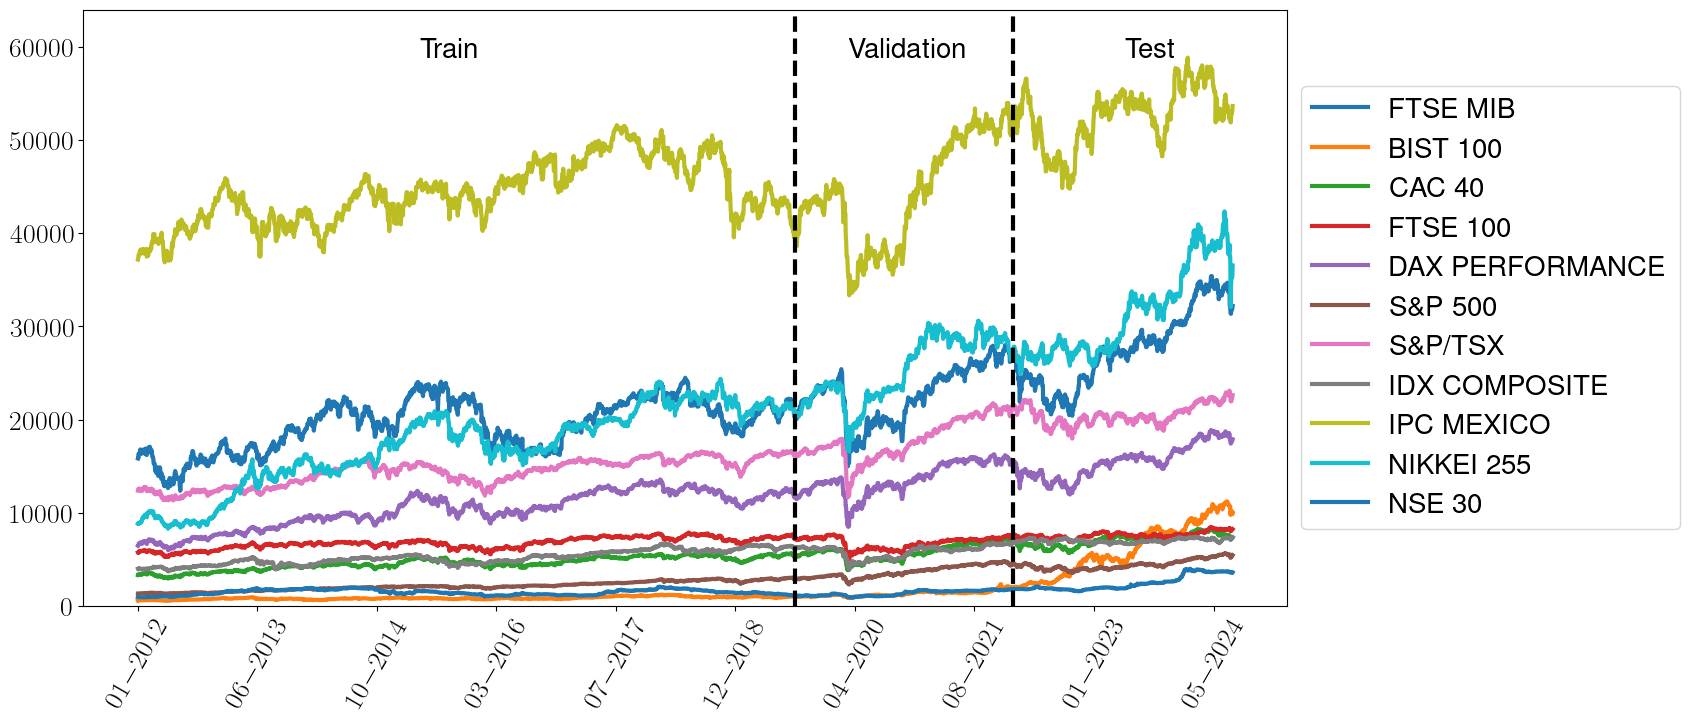

In [73]:
mod_data = original_data.map(lambda x: np.exp(x))
labels=[]

fig = plt.figure(figsize=(8.5*2, 11/3*2))
ax = fig.add_subplot(1,1,1)
ax.plot(idx, mod_data, label=['FTSE MIB', 'BIST 100', 'CAC 40', 'FTSE 100', 'DAX PERFORMANCE', 'S\&P 500', 'S\&P/TSX', 'IDX COMPOSITE', 'IPC MEXICO', 'NIKKEI 255', 'NSE 30'], linewidth=3)
ax.vlines(dt.datetime(2019, 8, 8), 0, 64_000, color='black', linewidth=3, linestyle='dashed')
ax.vlines(dt.datetime(2022, 2, 9), 0, 64_000, color='black', linewidth=3, linestyle='dashed')
# ax.set_title("All data", fontsize=20)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
ax.text(0.28, 0.92, 'Train', fontsize=20, transform=ax.transAxes, fontweight='bold')
ax.text(0.635, 0.92, 'Validation', fontsize=20, transform=ax.transAxes, fontweight='bold')
ax.text(0.865, 0.92, 'Test', fontsize=20, transform=ax.transAxes, fontweight='bold')
plt.xticks(rotation=60)
plt.legend(loc='center left', fontsize=20, bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_ylim(0, 64_000)
ax.set_xticks(idx[::500])
#     ax.set_xticks([])
    

fig.tight_layout()
fig.savefig("alldata.eps", format='eps', dpi=1000, bbox_inches='tight', pad_inches=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


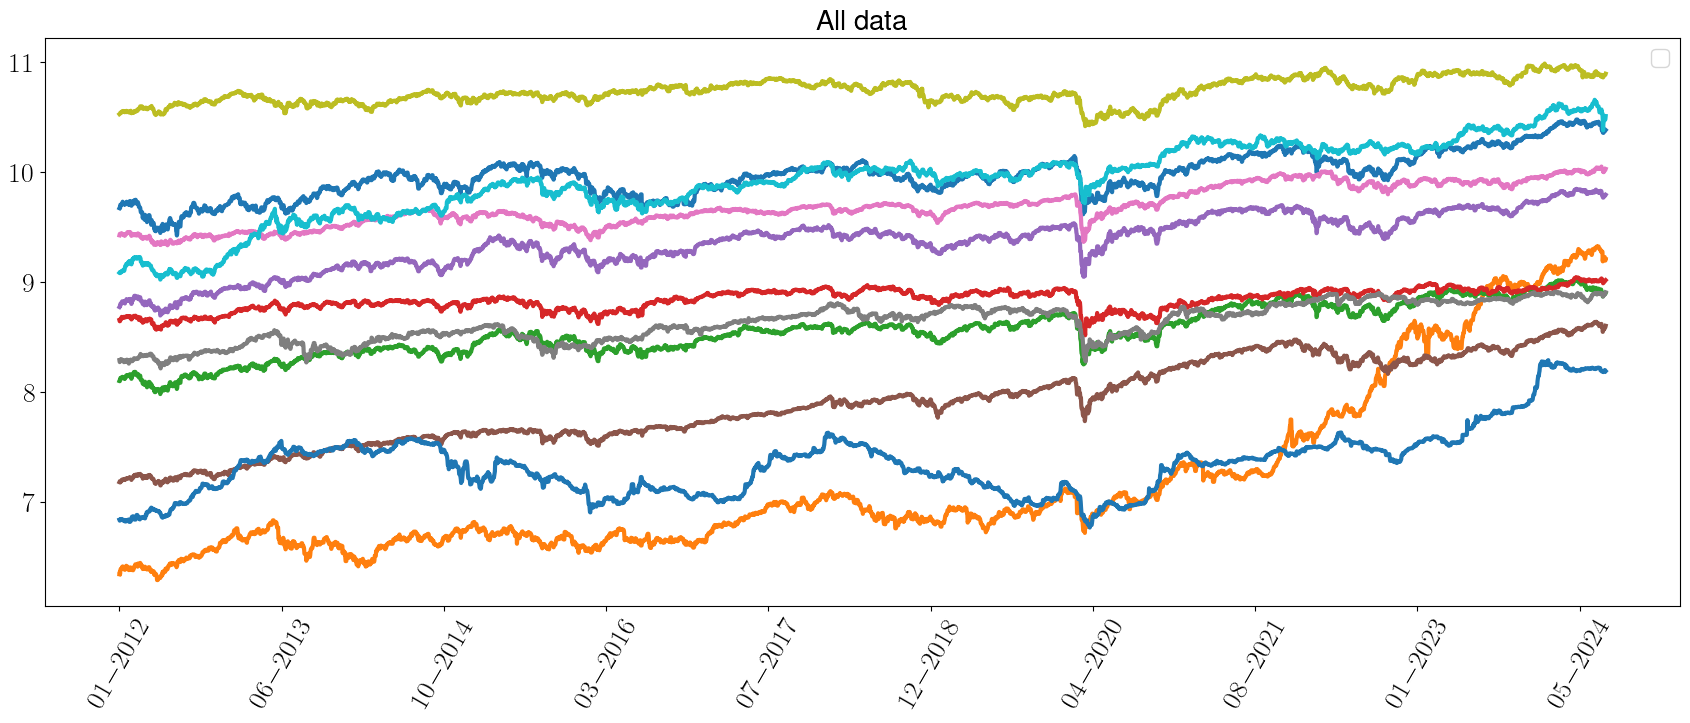

In [44]:
fig = plt.figure(figsize=(8.5*2, 11/3*2))
ax = fig.add_subplot(1,1,1)
ax.plot(idx, original_data, linewidth=3)
ax.set_title("All data", fontsize=20)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
plt.xticks(rotation=60)
plt.legend(loc='best', fontsize=16)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xticks(idx[::500])
#     ax.set_xticks([])
    

fig.tight_layout()

In [28]:
original_data['FTSEMIB.MI'].shape, idx.shape

((4581,), (4581,))